1. **Introduction**
   - Explain the purpose of Class Activation Maps (CAM) and their role in understanding CNN decisions.
   - Mention the algorithms to be covered: Grad Cam, Grad Cam Plus Plus, Score Cam, and Faster Score Cam.

2. **Installation and Setup**
   - Install the necessary libraries, including the visualization package used in previous lessons.
   - Load the pre-trained Keras model (e.g., Big 16 model).


# Import dependencies

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus
print(f"{num_of_gpus()}")


%reload_ext autoreload
#This reloads external modules automatically before code execution.

%autoreload 2
#Automatically reload all modules for every code execution.

%matplotlib inline
#This sets up the notebook to display Matplotlib plots inline.


(1, 1)


# Load a keras pretrained model

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

model = VGG16(weights = 'imagenet', include_top = True)
model.summary()

553467096/553467096 [==============================] - 257s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

3. **Download Test Images**
   - Download the test images to be used for CAM visualization.


4. **Visualizing Test Images**
   - Display the test images using the `matplotlib` library to verify their correctness.


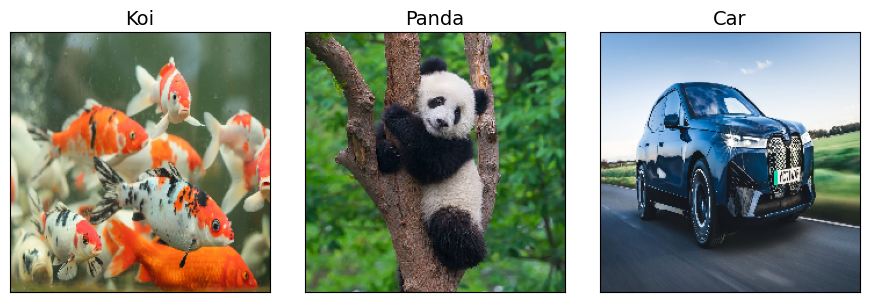

In [18]:
from tensorflow.keras.preprocessing.image import load_img

image_titles = ['Koi', 'Panda', 'Car']
#Create a list image_titles containing the titles of the images to be displayed.




img1 = load_img('koi.jpg', target_size=(224, 224))
img2 = load_img('panda.jpg', target_size=(224, 224))
img3 = load_img('car.jpg', target_size=(224, 224))
# The images are loaded using load_img with a target size of (224, 224)
# Which resizes the images to the specified dimensions.





images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])
# Convert the loaded images into a NumPy array using np.array().
#The np.asarray() function then converts the list of NumPy arrays 
# into a single NumPy array called images.





X = preprocess_input(images)
# The preprocess_input function adjusts the pixel values of the images 
# to be compatible with the pre-trained VGG16 model.





subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
#Define a dictionary subplot_args containing arguments for creating a subplot:
#'nrows': 1: The number of rows in the subplot (one row).
#'ncols': 3: The number of columns in the subplot (three columns).
#'figsize': (9, 3): The size of the entire figure (width, height) in inches.
#'{'xticks': [], 'yticks': []}: Keyword arguments for each subplot, setting the x-axis and y-axis ticks to be empty.

        
        
        
        
        

f, ax = plt.subplots(**subplot_args)
# Create a subplot using the plt.subplots() function 
# with the arguments specified in subplot_args.
# The figure object f and an array of axes objects ax are returned.  




for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

# Define loss function

In [19]:
# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
# The ImageNet class number for "car," "panda," and "koi" are as follows:

# 1. Car: Class Number 817
# 2. Panda: Class Number 388
# 3. Koi: Class Number 1

def loss(output):
    return (output[0][1], output[1][388], output[2][817])

# Define model modifier function

In [20]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

5. **Implementing Grad Cam**
   - Create a function to extract the output of the second-to-last layer (penultimate layer) from the model.
   - Implement Grad Cam using the visualization package:
     - Pass the model, model modifier, loss, X (input data), and the penultimate layer output to create a Grad Cam object.
     - Use normalization to create a heatmap and visualize it.


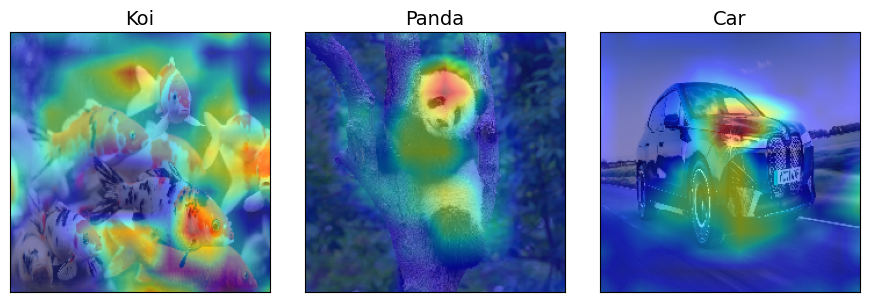

CPU times: total: 7.38 s
Wall time: 22.8 s


In [21]:
%%time
#The %%time magic command is used to measure the execution time of the following code block.




from tensorflow.keras import backend as K
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam





gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)
# Create a Gradcam object to generate GradCAM heatmaps.
# model: The pre-trained VGG16 model that was loaded previously.
# model_modifier: A modifier function (if any) to be applied to the model. 
# It might be used to modify the model architecture, but here it is not explicitly defined.
# clone=False: This flag indicates whether to clone the model. 
#Setting it to False means we are using the existing model, not a cloned version.

    
    
    
cam = gradcam(loss,
              X,
              penultimate_layer=-1, 
             )
# Generate GradCAM heatmaps using the gradcam() method of the Gradcam object.
# loss: The loss function to be used for computing the gradients. 
# It was defined previously in the notebook.
# X: The preprocessed input images images as a NumPy array.
# penultimate_layer=-1: The index of the layer to be used as the penultimate layer. 
#Here, it is set to -1, which refers to the last layer of the model.







cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
plt.tight_layout()
plt.show()

6. **Visualizing Grad Cam for Different Classes**
   - Apply Grad Cam to each test image for specific classes (e.g., goldfish, bear, assault rifle).
   - Analyze the heatmaps to identify regions where the CNN focuses its attention.


# Do the same thing with GradCAM++ 

7. **Grad Cam Plus Plus**
   - Implement Grad Cam Plus Plus:
     - Import Grad Cam Plus from the visualization package.
     - Create a Grad Cam Plus object by passing the model, model modifier, loss, X, and the penultimate layer output.
     - Use normalization to generate and visualize the heatmap.


8. **Visualizing Grad Cam Plus Plus**
   - Apply Grad Cam Plus Plus to the test images for different classes.
   - Compare the heatmaps with those from basic Grad Cam.


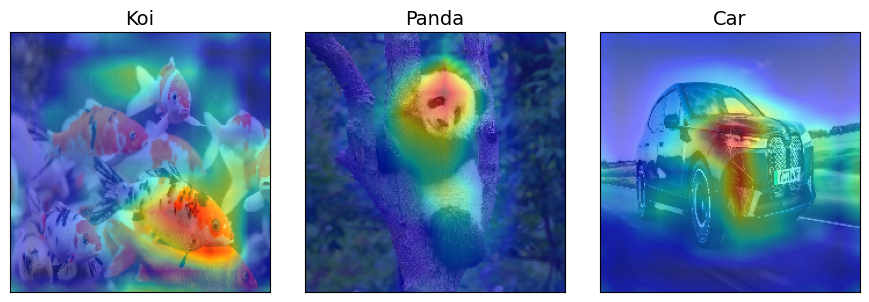

CPU times: total: 734 ms
Wall time: 1.4 s


In [22]:
%%time

from tf_keras_vis.gradcam import GradcamPlusPlus

# Create GradCAM++ object, Just only repalce class name to "GradcamPlusPlus"
# gradcam = Gradcam(model, model_modifier, clone=False)
gradcam = GradcamPlusPlus(model,
                          model_modifier,
                          clone=False)

# Generate heatmap with GradCAM++
cam = gradcam(loss,
              X,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

9. **Score Cam**
   - Explain that Score Cam is a gradient-free method for generating class activation maps.
   - Note that Score Cam may take longer to compute than other methods.
   - Import Score Cam from the visualization package.
   - Modify the model to use Score Cam instead of Grad Cam.
   - Visualize the generated heatmaps.


48/48 [==============================] - 13s 198ms/step


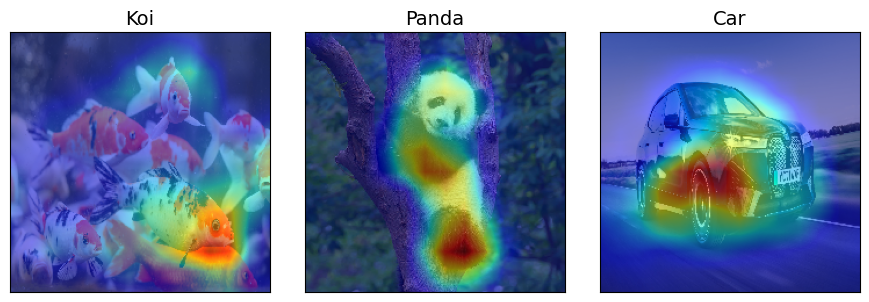

CPU times: total: 21.2 s
Wall time: 40.4 s


In [25]:
%%time

from tf_keras_vis.scorecam import ScoreCAM

_, gpus = num_of_gpus()
# Create ScoreCAM object
scorecam = ScoreCAM(model, model_modifier, clone=False)

# This cell takes toooooooo much time, so only doing with GPU.
if gpus > 0:
    # Generate heatmap with ScoreCAM
    cam = scorecam(loss,
                   X,
                   penultimate_layer=-1, # model.layers number
                  )
    cam = normalize(cam)

    f, ax = plt.subplots(**subplot_args)
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=14)
        ax[i].imshow(images[i])
        ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("NOTE: Change to GPU to see visual output\n")


10. **Faster Score Cam**
    - Explain that Faster Score Cam is a faster version of Score Cam.
    - Import Faster Score Cam from the visualization package.
    - Use the modified model with Faster Score Cam to visualize the heatmaps.


3/3 [==============================] - 4s 2s/step


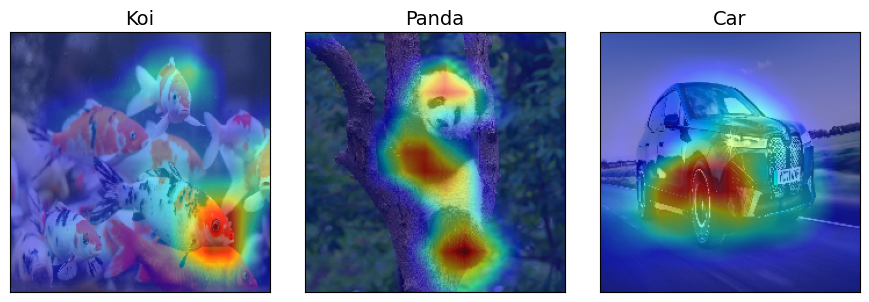

CPU times: total: 3.06 s
Wall time: 6.03 s


In [26]:
%%time

# Create ScoreCAM object
scorecam = ScoreCAM(model, model_modifier, clone=False)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(loss,
               X,
               penultimate_layer=-1, # model.layers number
               max_N=10
              )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

# Key differences between Grad Cam, Grad Cam Plus Plus, Score Cam, and Faster Score Cam.



|              | Grad Cam                          | Grad Cam Plus Plus                 | Score Cam                   | Faster Score Cam            |
|--------------|-----------------------------------|-----------------------------------|-----------------------------|-----------------------------|
| Algorithm    | Gradient-based                    | Gradient-based                    | Gradient-free               | Gradient-free               |
| Explanation  | Highlights important regions      | Highlights important regions      | Highlights important regions| Highlights important regions|
|              | based on gradient information    | based on gradient information    | without using gradients     | without using gradients     |
| Interpretability | Interpretable heatmaps         | Interpretable heatmaps         | Interpretable heatmaps      | Interpretable heatmaps      |
| Model Layer  | Typically uses the last          | Typically uses the last          | Can use any layer          | Can use any layer          |
|              | convolutional layer              | convolutional layer              |                             |                             |
| Tuning       | Requires tuning hyperparameters  | Requires tuning hyperparameters  | Requires minimal tuning     | Requires minimal tuning     |
| Performance  | May be computationally expensive | May be computationally expensive | Efficient                   | Efficient                   |
| Pros         | Widely used and easy to implement| Improves localization accuracy   | No gradient computation     | No gradient computation     |
|              | Good interpretability            | Better heatmaps for some models   | Less sensitive to noise     | Less sensitive to noise     |
| Cons         | Can suffer from noise            | Complexity may lead to overfitting| Less detailed heatmaps      | Less detailed heatmaps      |

